In [1]:
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import matplotlib.pyplot as plt

In [3]:
import os

In [4]:
import sys
from scipy.spatial.transform import Rotation

load image

In [5]:
class CameraPose:

    def __init__(self, meta, mat):
        self.metadata = meta
        self.pose = mat

    def __str__(self):
        return 'Metadata : ' + ' '.join(map(str, self.metadata)) + '\n' + \
            "Pose : " + "\n" + np.array_str(self.pose)


def read_trajectory(filename):
    traj = []
    with open(filename, 'r') as f:
        metastr = f.readline()
        while metastr:
            metadata = list(map(int, metastr.split()))
            mat = np.zeros(shape=(4, 4))
            for i in range(4):
                matstr = f.readline()
                mat[i, :] = np.fromstring(matstr, dtype=float, sep=' \t')
            traj.append(CameraPose(metadata, mat))
            metastr = f.readline()
    return traj



In [6]:
def readPosesTXT(fpath):
    
    if os.path.isfile(fpath) == False:
        print("Cannot find poses: '%s'"%fpath)
        sys.exit()

    data = np.loadtxt(fpath, dtype='float_', delimiter=' ')
    
    N = data.shape[0]
    eye = np.eye(4, dtype=np.float32)
    eye = np.expand_dims(eye, axis=0)
    poses = np.repeat(eye, N, axis=0)
    
    if data.shape[1] == 8:
    
        # Assuming RGBD-SLAM format
        timestamps = data[:,0]
        qts = data[:,4:]
        tvecs = data[:,1:4]
        
        for i, (qt, t) in enumerate(zip(qts,tvecs)):
            rot = Rotation.from_quat(qt)
            R = rot.as_matrix()
            poses[i,:3,:3] = R
            poses[i,:3,3] = t
            
        return poses, timestamps

    else:
        print("Check the format of the camera poses: '%s'" %fpath)
        sys.exit()

In [ ]:
redwood_rgbd = o3d.data.SampleRedwoodRGBDImages()
camera_poses = read_trajectory(redwood_rgbd.odometry_log_path)

In [ ]:
volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

for i in range(len(camera_poses)):
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image(redwood_rgbd.color_paths[i])
    depth = o3d.io.read_image(redwood_rgbd.depth_paths[i])
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)
    volume.integrate(
        rgbd,
        o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault),
        np.linalg.inv(camera_poses[i].pose))



In [ ]:
print("Extract a triangle mesh from the volume and visualize it.")
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh],
                                  front=[0.5297, -0.1873, -0.8272],
                                  lookat=[2.0712, 2.0312, 1.7251],
                                  up=[-0.0558, -0.9809, 0.1864],
                                  zoom=0.47)

In [ ]:
print("Read TUM dataset")
tum_rgbd = o3d.data.SampleSUNRGBDImage()
color_raw = o3d.io.read_image(tum_rgbd.color_path)
depth_raw = o3d.io.read_image(tum_rgbd.depth_path)
rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(color_raw, depth_raw)
print(rgbd_image)

In [ ]:
plt.subplot(1, 2, 1)
plt.title('TUM grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('TUM depth image')
plt.imshow(rgbd_image.depth)
plt.show()



In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

cwc dataset loading image

In [7]:
print("Read CWC dataset")
cwc_rgbd = o3d.data.SampleSUNRGBDImage()
color_raw = o3d.io.read_image("../data/cwc/color/1000000.117744.jpg")
depth_raw = o3d.io.read_image("../data/cwc/depth/1000000.117744.png")
cwc_rgbd_image = o3d.geometry.RGBDImage.create_from_tum_format(color_raw, depth_raw)
print(cwc_rgbd_image)

Read CWC dataset
RGBDImage of size 
Color image : 1280x720, with 1 channels.
Depth image : 1280x720, with 1 channels.
Use numpy.asarray to access buffer data.


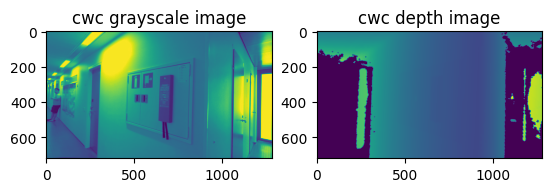

In [8]:
plt.subplot(1, 2, 1)
plt.title('cwc grayscale image')
plt.imshow(cwc_rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('cwc depth image')
plt.imshow(cwc_rgbd_image.depth)
plt.show()

In [ ]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    cwc_rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

In [9]:
cwc_rgbd = o3d.data.SampleSUNRGBDImage()


In [10]:
#cwc_poses = read_trajectory("../data/cwc/poses/poses_color.txt")

In [11]:
color_list = os.listdir("../data/cwc/color")
depth_list = os.listdir("../data/cwc/depth")
color_list.sort()
depth_list.sort()

In [12]:
print(color_list[0])
print(depth_list[0])

1000000.117744.jpg
1000000.117744.png


In [13]:
cwc_poses, cwc_timestamps = readPosesTXT("../data/cwc/poses/poses_color.txt")

In [14]:
cwc_volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

#intrinsic camera settings
w = 1280
h = 720
fx = 525
fy = 525
cx = 319.5
cy = 239.5

intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)
intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
cam = o3d.camera.PinholeCameraParameters()
cam.intrinsic = intrinsic

#for i in range(len(color_list)):
for i in range(64):
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image("../data/cwc/color/" + color_list[i])
    depth = o3d.io.read_image("../data/cwc/depth/" + depth_list[i])
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)
    cwc_volume.integrate(
        rgbd,
        cam.intrinsic,
        np.linalg.inv(cwc_poses[i]))

Integrate 0-th image into the volume.
Integrate 1-th image into the volume.
Integrate 2-th image into the volume.
Integrate 3-th image into the volume.
Integrate 4-th image into the volume.
Integrate 5-th image into the volume.
Integrate 6-th image into the volume.
Integrate 7-th image into the volume.
Integrate 8-th image into the volume.
Integrate 9-th image into the volume.
Integrate 10-th image into the volume.
Integrate 11-th image into the volume.
Integrate 12-th image into the volume.
Integrate 13-th image into the volume.
Integrate 14-th image into the volume.
Integrate 15-th image into the volume.
Integrate 16-th image into the volume.
Integrate 17-th image into the volume.
Integrate 18-th image into the volume.
Integrate 19-th image into the volume.
Integrate 20-th image into the volume.
Integrate 21-th image into the volume.
Integrate 22-th image into the volume.
Integrate 23-th image into the volume.
Integrate 24-th image into the volume.
Integrate 25-th image into the volu

In [16]:
print("Extract a triangle mesh from the volume and visualize it.")
mesh = cwc_volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

Extract a triangle mesh from the volume and visualize it.


cwc mini testing

In [ ]:
print("Read CWC mini dataset")
cwc_rgbd_mini = o3d.data.SampleSUNRGBDImage()
color_raw_mini = o3d.io.read_image("../data/cwc_mini/color/1000000.117744.jpg")
depth_raw_mini = o3d.io.read_image("../data/cwc_mini/depth/1000000.117744.png")
cwc_rgbd_image_mini = o3d.geometry.RGBDImage.create_from_tum_format(color_raw_mini, depth_raw_mini)
print(cwc_rgbd_image_mini)

In [ ]:
plt.subplot(1, 2, 1)
plt.title('cwc grayscale image')
plt.imshow(cwc_rgbd_image_mini.color)
plt.subplot(1, 2, 2)
plt.title('cwc depth image')
plt.imshow(cwc_rgbd_image_mini.depth)
plt.show()

In [ ]:
pcd_mini = o3d.geometry.PointCloud.create_from_rgbd_image(
    cwc_rgbd_image_mini,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd_mini.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd_mini])

Integration

In [ ]:
color_list_mini = os.listdir("../data/cwc_mini/color")
depth_list_mini = os.listdir("../data/cwc_mini/depth")

In [ ]:
color_list_mini.sort()
depth_list_mini.sort()
print(color_list_mini[0])
print(depth_list_mini[0])

In [ ]:
cwc_poses_mini, cwc_timestamps_mini = readPosesTXT("../data/cwc_mini/poses/poses_color.txt")

In [ ]:
print(cwc_poses_mini[0])

In [ ]:
i = 0
cwc_volume_mini = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

In [ ]:
print("Integrate {:d}-th image into the volume.".format(i))
color = o3d.io.read_image("../data/cwc_mini/color/" + color_list_mini[i])
depth = o3d.io.read_image("../data/cwc_mini/depth/" + depth_list_mini[i])

#intrinsic camera settings
w = 1280
h = 720
fx = 525
fy = 525
cx = 319.5
cy = 239.5

intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx, fy, cx, cy)
intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
cam = o3d.camera.PinholeCameraParameters()
cam.intrinsic = intrinsic


rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)

plt.subplot(1, 2, 1)
plt.title('cwc grayscale image')
plt.imshow(rgbd.color)
plt.subplot(1, 2, 2)
plt.title('cwc depth image')
plt.imshow(rgbd.depth)
plt.show()

#cwc_volume_mini.integrate(
#    rgbd,
#    o3d.camera.PinholeCameraIntrinsic(
#        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault),
#    np.linalg.inv(cwc_poses_mini[i]))



In [ ]:
cam_mini = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)
print(cam_mini.intrinsic_matrix)

In [ ]:
#integrating with custom camera settings
cwc_volume_mini.integrate(
    rgbd,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault),
    cwc_poses_mini[i])

In [ ]:
#integrating with custom camera settings
cwc_volume_mini.integrate(
    rgbd,
    cam.intrinsic,
    cwc_poses_mini[i])

In [ ]:
print("Extract a triangle mesh from the volume and visualize it.")
mesh = cwc_volume_mini.extract_triangle_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

In [ ]:
cwc_volume = o3d.pipelines.integration.ScalableTSDFVolume(
    voxel_length=4.0 / 512.0,
    sdf_trunc=0.04,
    color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

for i in range(len(color_list_mini)):
    print("Integrate {:d}-th image into the volume.".format(i))
    color = o3d.io.read_image("../data/cwc_mini/color/" + color_list_mini[i])
    depth = o3d.io.read_image("../data/cwc_mini/depth/" + depth_list_mini[i])
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)
    cwc_volume.integrate(
        rgbd,
        cam.intrinsic,
        np.linalg.inv(cwc_poses_mini[i]))

In [ ]:
print("Extract a triangle mesh from the volume and visualize it.")
mesh = cwc_volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh])

In [ ]:
o3d.visualization.draw_plotly([mesh])